In [1]:
import os
# set tmp file dir to local.
# NOTE: this is important. not setting the tmp dir will casue the os drive to be OOM.
temp_path = os.path.join("/media/kwanz/New Volume/deepfake/", "tmp")
if not os.path.exists(temp_path):
    os.makedirs(temp_path)

os.environ["TMPDIR"]=temp_path
os.environ["TEMP"]=temp_path
os.environ["TORCH_EXTENSIONS_DIR"]=temp_path
os.environ["TORCH_HOME"]=temp_path
os.environ["HF_HOME"]=temp_path

import tempfile
tempfile.tempdir=temp_path
import torch
torch.hub.set_dir(temp_path)

import sys
# so to include libs in parent dir such as lib
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets
from torchvision.models import resnet101, ResNet101_Weights, efficientnet_b4, EfficientNet_B4_Weights
from tqdm import tqdm
import clip

In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    # List the name of each GPU
    for i in range(num_gpus):
        device_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {device_name}")
else:
    print("CUDA is not available. Using CPU.")

GPU 0: NVIDIA RTX A6000


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Utils

In [6]:
def set_seed(seed):
    """Set seed for reproducibility across Python, NumPy, and PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
# Function to calculate DCF
def compute_dcf(y_true, y_pred, C_miss=1, C_fa=1, P_target=0.5):
    """
    Computes the Detection Cost Function (DCF).
    Args:
        y_true (torch.Tensor): True labels (0s and 1s).
        y_pred (torch.Tensor): Predicted probabilities.
        C_miss (float): Cost of misses.
        C_fa (float): Cost of false alarms.
        P_target (float): Prior probability of the target class.
    Returns:
        float: DCF score.
    """
    y_pred = (y_pred >= 0.5).float()
    fn = ((y_true == 1) & (y_pred == 0)).sum().item()
    fp = ((y_true == 0) & (y_pred == 1)).sum().item()
    tn = ((y_true == 0) & (y_pred == 0)).sum().item()
    tp = ((y_true == 1) & (y_pred == 1)).sum().item()

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False negative rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False positive rate

    dcf = C_miss * P_target * fnr + C_fa * (1 - P_target) * fpr
    return dcf

In [8]:
class EarlyStopping:
    """Early stopping to stop training when DCF doesn't improve after a certain patience."""
    def __init__(self, patience=5, verbose=False, delta=0, path='../models/best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path

    def __call__(self, dcf, model):
        score = -dcf  # We use negative DCF because lower is better

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(dcf, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(dcf, model)
            self.counter = 0

    def save_checkpoint(self, dcf, model):
        if self.verbose:
            print(f'DCF improved, saving model ...')
        torch.save(model.state_dict(), self.path)

## Model

In [9]:
class CLIPExtractor(nn.Module):
    def __init__(self, model_type="ViT-B/32", device="cuda", download_dir=None):
        super(CLIPExtractor, self).__init__()
        self.device = device
        self.model, self.preprocess = clip.load(model_type, device=device, download_root=download_dir)
        
        # Text prompt for analysis
        self.prompt = [
            "Analyze the image for indicators of authenticity or manipulation, "
            "focusing on natural textures, lighting, facial feature consistency, "
            "background realism, and possible artifacts such as mismatched reflections, "
            "edge transitions, or unnatural elements."
        ]
        self.text_tokens = clip.tokenize(self.prompt).to(device)

    def forward(self, images):
        """
        Forward pass to extract features.
        
        Args:
            images: A batch of preprocessed images [batch_size, 3, 224, 224].
        
        Returns:
            image_features: Image embeddings for the batch [batch_size, feature_dim].
            text_features: Text embeddings for the prompt [1, feature_dim].
            similarity: Optional similarity scores [batch_size].
        """
        images = images.to(self.device)

        # Extract embeddings
        with torch.no_grad():
            image_features = self.model.encode_image(images)  # [batch_size, feature_dim]
            text_features = self.model.encode_text(self.text_tokens)  # [1, feature_dim]

        # Normalize the embeddings
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        text_features = text_features.expand(images.size(0), -1)
        
        return image_features, text_features


In [10]:
class ResnetModel(nn.Module):
    def __init__(self):
        super(ResnetModel, self).__init__()
        self.model = resnet101(weights=ResNet101_Weights.DEFAULT)
        
        self.model.fc = nn.Linear(2048, 512)

    def forward(self, x):
        x = x.to(device)
        return self.model(x)

In [11]:
class ENetModel(nn.Module):
    def __init__(self):
        super(ENetModel, self).__init__()
        self.model = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)

        for param in self.model.features.parameters():
            param.requires_grad = True

        in_features = self.model.classifier[1].in_features
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(in_features, 512)
        )
    
    def forward(self, x):
        x = x.to(device)
        return self.model(x)

In [ ]:
class ChannelAttentionModule(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttentionModule, self).__init__()
        # Reduction layer: Reduces channel dimensions to a smaller embedding size
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.fc1 = nn.Linear(in_channels, in_channels // reduction_ratio, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_channels // reduction_ratio, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input: (batch_size, channels, height, width)
        b, c, _, _ = x.size()

        # Global average pooling
        avg_out = self.avg_pool(x).view(b, c)

        # Fully connected layers
        out = self.fc1(avg_out)
        out = self.relu(out)
        out = self.fc2(out)
        weights = self.sigmoid(out).view(b, c, 1, 1)

        # Apply learned weights
        return x * weights


In [12]:
class CustomClassifier(nn.Module):
    def __init__(self):
        super(CustomClassifier, self).__init__()
        # Define dimensions
        cnn_channels = 512
        vlm_channels = 512 * 2  # Combined size of CLIP image and text embeddings
        fused_channels = 256  # Output channels after dimensionality reduction
        reduction_ratio = 16

        # Channel Attention Modules
        self.cnn_cam = ChannelAttentionModule(cnn_channels, reduction_ratio)
        self.vlm_cam = ChannelAttentionModule(vlm_channels, reduction_ratio)

        # 1x1 Convolutions for dimensionality reduction
        self.cnn_reduce = nn.Conv2d(cnn_channels, fused_channels, kernel_size=1)
        self.vlm_reduce = nn.Conv2d(vlm_channels, fused_channels, kernel_size=1)

        # Fusion layer (concatenation followed by convolution)
        self.fusion = nn.Conv2d(fused_channels * 2, fused_channels, kernel_size=1)

        # Fully connected layers for classification
        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Flatten(),
            nn.Linear(fused_channels, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 1),
            nn.Sigmoid()  # Binary classification
        )

    def forward(self, bb_embed, img_emb, text_emb):
        # bb_embed, img_emb, text_emb are expected to be in shape [batch, channels, height, width]
        # Apply Channel Attention Modules
        cnn_attended = self.cnn_cam(bb_embed)
        vlm_attended = self.vlm_cam(torch.cat([img_emb, text_emb], dim=1))

        # Reduce dimensions
        cnn_reduced = self.cnn_reduce(cnn_attended)
        vlm_reduced = self.vlm_reduce(vlm_attended)

        # Fuse features
        fused = torch.cat([cnn_reduced, vlm_reduced], dim=1)
        fused = self.fusion(fused)

        # Pass through MLP for classification
        output = self.mlp(fused)
        return output


In [13]:
class CustomModel(nn.Module):
    def __init__(self, backbone_model):
        super(CustomModel, self).__init__()
        self.backbone = backbone_model
        self.extractor = CLIPExtractor().to(device)
        self.classifier = CustomClassifier().to(device)
        self.clip_preprocess = self.extractor.preprocess
        
    def forward(self, x):
        img_emb, text_emb = self.extractor(x)  # get text embeddings based on img
        
        bb_embed = self.backbone(x)  # get image embeddings
        x = self.classifier(img_emb, text_emb, bb_embed)
        return x
    
    def load_data(self, batch_size):
        train_data = datasets.ImageFolder("../data/train", transform=self.clip_preprocess)

        valid_data = datasets.ImageFolder("../data/valid", transform=self.clip_preprocess)

        self.train_loader = DataLoader(
            train_data, 
            batch_size=batch_size, 
            shuffle=True,
            num_workers=4
        )

        self.valid_loader = DataLoader(
            valid_data, 
            batch_size=batch_size, 
            shuffle=False,
            num_workers=1
        )
    
    def start_training(
            self, criterion, optimizer, 
            scheduler, early_stopping, num_epochs
        ):
        train_losses = []
        val_losses = []
        
        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            with tqdm(self.train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
                for images, labels in pbar:
                    labels = labels.float().unsqueeze(1).to(device)

                    outputs = self(images)
                    loss = criterion(outputs, labels)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    pbar.set_postfix({"Train Loss": f"{running_loss / (pbar.n + 1):.4f}"})

            # Store training loss for the epoch
            epoch_train_loss = running_loss / len(self.train_loader)
            train_losses.append(epoch_train_loss)

            # Validation
            self.eval()
            val_running_loss = 0.0
            correct = 0
            total = 0
            y_true = []
            y_pred = []
            with torch.no_grad():
                with tqdm(self.valid_loader, desc="Validation", unit="batch", leave=False) as val_pbar:
                    for images, labels in val_pbar:
                        images = images.to(device)
                        labels = labels.float().to(device)
                        outputs = self(images).squeeze()
                        val_loss_batch = criterion(outputs, labels)
                        val_running_loss += val_loss_batch.item()

                        # Calculate accuracy
                        predicted = (outputs >= 0.5).float()  # Threshold for binary classification
                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                        y_true.append(labels.cpu())
                        y_pred.append(outputs.cpu())

            # Store validation loss for the epoch
            epoch_val_loss = val_running_loss / len(self.valid_loader)
            val_losses.append(epoch_val_loss)

            y_true = torch.cat(y_true)
            y_pred = torch.cat(y_pred)
            dcf = compute_dcf(y_true, y_pred)
            val_accuracy = 100 * correct / total

            # Step the scheduler
            scheduler.step(dcf)

            # Early stopping step
            early_stopping(dcf, self)

            print(f'Validation DCF: {dcf:.4f} | Acc: {val_accuracy:.2f} | lr: {scheduler._last_lr}\n')

            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        print("Training complete!")
        return train_losses, val_losses
    

## Params

In [14]:
batch_size = 64
seed = 42
lr = 1e-4
num_epochs = 30
set_seed(seed)

In [16]:
model = CustomModel(backbone_model=ResnetModel()).to(device)

In [42]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
early_stopping = EarlyStopping(patience=10, verbose=True)

## Train

Epoch [1/30]: 100%|██████████| 4097/4097 [16:37<00:00,  4.11batch/s, Train Loss=0.0809]


DCF improved, saving model ...
Validation DCF: 0.1097 | Acc: 89.00 | lr: [0.0001]



Epoch [2/30]: 100%|██████████| 4097/4097 [16:37<00:00,  4.11batch/s, Train Loss=0.0312]


EarlyStopping counter: 1 out of 10
Validation DCF: 0.1703 | Acc: 82.88 | lr: [0.0001]



Epoch [3/30]: 100%|██████████| 4097/4097 [16:37<00:00,  4.11batch/s, Train Loss=0.0235]


EarlyStopping counter: 2 out of 10
Validation DCF: 0.1284 | Acc: 87.11 | lr: [0.0001]



Epoch [4/30]: 100%|██████████| 4097/4097 [17:00<00:00,  4.02batch/s, Train Loss=0.0200]


EarlyStopping counter: 3 out of 10
Validation DCF: 0.1355 | Acc: 86.46 | lr: [0.0001]



Epoch [5/30]: 100%|██████████| 4097/4097 [16:37<00:00,  4.11batch/s, Train Loss=0.0173]


EarlyStopping counter: 4 out of 10
Validation DCF: 0.1350 | Acc: 86.46 | lr: [0.0001]



Epoch [6/30]: 100%|██████████| 4097/4097 [16:36<00:00,  4.11batch/s, Train Loss=0.0150]


DCF improved, saving model ...
Validation DCF: 0.0898 | Acc: 91.02 | lr: [0.0001]



Epoch [7/30]: 100%|██████████| 4097/4097 [16:37<00:00,  4.11batch/s, Train Loss=0.0133]


EarlyStopping counter: 1 out of 10
Validation DCF: 0.1095 | Acc: 89.00 | lr: [0.0001]



Epoch [8/30]: 100%|██████████| 4097/4097 [16:37<00:00,  4.11batch/s, Train Loss=0.0114]


EarlyStopping counter: 2 out of 10
Validation DCF: 0.1293 | Acc: 87.04 | lr: [0.0001]



Epoch [9/30]: 100%|██████████| 4097/4097 [16:37<00:00,  4.11batch/s, Train Loss=0.0105]


EarlyStopping counter: 3 out of 10
Validation DCF: 0.1353 | Acc: 86.39 | lr: [0.0001]



Epoch [10/30]: 100%|██████████| 4097/4097 [16:37<00:00,  4.11batch/s, Train Loss=0.0099]


EarlyStopping counter: 4 out of 10
Validation DCF: 0.1266 | Acc: 87.27 | lr: [0.0001]



Epoch [11/30]: 100%|██████████| 4097/4097 [17:33<00:00,  3.89batch/s, Train Loss=0.0087]


EarlyStopping counter: 5 out of 10
Validation DCF: 0.1207 | Acc: 87.92 | lr: [0.0001]



Epoch [12/30]: 100%|██████████| 4097/4097 [18:40<00:00,  3.66batch/s, Train Loss=0.0086]


EarlyStopping counter: 6 out of 10
Validation DCF: 0.1534 | Acc: 84.57 | lr: [1e-05]



Epoch [13/30]: 100%|██████████| 4097/4097 [18:06<00:00,  3.77batch/s, Train Loss=0.0034]


EarlyStopping counter: 7 out of 10
Validation DCF: 0.0941 | Acc: 90.56 | lr: [1e-05]



Epoch [14/30]: 100%|██████████| 4097/4097 [18:23<00:00,  3.71batch/s, Train Loss=0.0015]


EarlyStopping counter: 8 out of 10
Validation DCF: 0.1083 | Acc: 89.13 | lr: [1e-05]



Epoch [15/30]: 100%|██████████| 4097/4097 [19:00<00:00,  3.59batch/s, Train Loss=0.0008]


EarlyStopping counter: 9 out of 10
Validation DCF: 0.1171 | Acc: 88.25 | lr: [1e-05]



Epoch [16/30]: 100%|██████████| 4097/4097 [18:56<00:00,  3.61batch/s, Train Loss=0.0006]
                                                              

EarlyStopping counter: 10 out of 10
Validation DCF: 0.1245 | Acc: 87.50 | lr: [1e-05]

Early stopping triggered at epoch 16
Training complete!


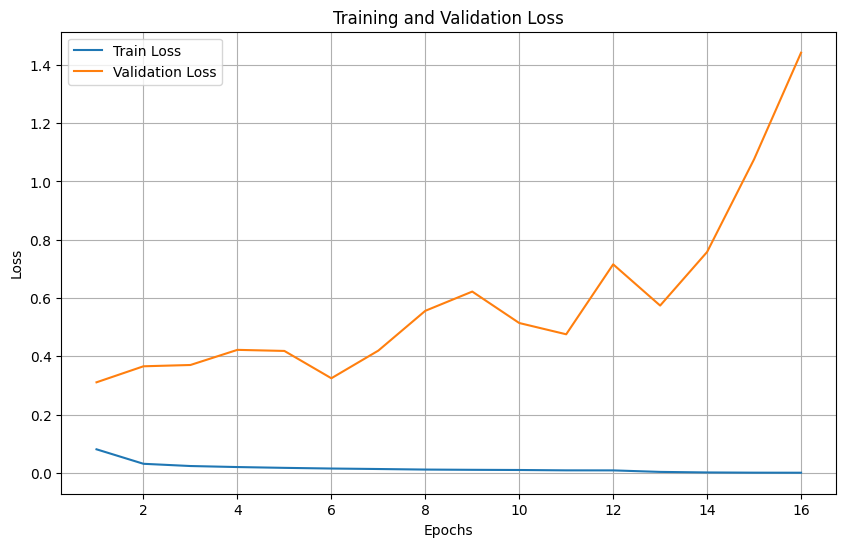

In [43]:
model.load_data(batch_size)
train_losses, val_losses = model.start_training(
    criterion, optimizer, scheduler, early_stopping, num_epochs
)

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [17]:
import torchvision.transforms as transforms
from PIL import Image

# Define a transformation to convert tensors back to images for display
to_pil_image = transforms.ToPILImage()

model = CustomModel(backbone_model=ResnetModel()).to(device)
# Load the trained model
model.load_state_dict(torch.load("../models/91_clip_extractor.pth"))
model.load_data(batch_size)
model = model.to(device)  # Move the model to the device
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
misclassified_labels = []  # To store corresponding labels
misclassified_predictions = []  # To store predicted values

with torch.no_grad():
    for images, labels in tqdm(model.valid_loader, desc="Evaluating Model"):
        images = images.to(device)
        labels = labels.float().to(device)
        outputs = model(images).squeeze()
        outputs = torch.sigmoid(outputs)
        # Apply threshold for binary classification
        predicted = (outputs >= 0.5).float()
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate and print accuracy
accuracy = 100 * correct / total

print(f'Model Accuracy: {accuracy:.2f}%')

/media/kwanz/New Volume/deepfake/tmp/ipykernel_225109/305749840.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("../models/91_clip_extra

Model Accuracy: 91.28%


In [18]:
torch.save(model, "../models/full_model.pth")

# GRADCAM

In [45]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
from torchvision.transforms.functional import normalize

class GradCAM:
    def __init__(self, model, target_layer):
        """
        Initialize Grad-CAM with a model and the target convolutional layer.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_tensor, class_idx=None):
        """
        Generate Grad-CAM heatmap.
        """
        self.model.eval()

        # Forward pass
        output = self.model(input_tensor)

        # If class_idx is None, take the class with the max score
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        output[:, class_idx].backward()

        # Compute Grad-CAM heatmap
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))  # Global Average Pooling on gradients
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)  # ReLU
        cam = cv2.resize(cam, (input_tensor.size(3), input_tensor.size(2)))  # Resize to input size
        cam -= np.min(cam)
        cam /= np.max(cam)
        return cam

    def overlay_heatmap(self, heatmap, image, alpha=0.5):
        """
        Overlay the Grad-CAM heatmap onto the original image.

        Args:
            heatmap: Grad-CAM heatmap (2D array).
            image: Original PIL image.
            alpha: Transparency level for the heatmap overlay.

        Returns:
            overlay: Heatmap blended with the original image.
        """
        # Ensure heatmap and image have the same dimensions
        image = np.array(image)  # Convert PIL image to NumPy array
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize heatmap

        # Normalize heatmap to [0, 255]
        heatmap = np.uint8(255 * heatmap)

        # Convert the heatmap to a color map
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        # Ensure the original image is in BGR format for OpenCV
        if image.shape[-1] == 3:  # If RGB
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Overlay heatmap on the original image
        overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

        # Convert back to RGB for display
        overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        return overlay



In [46]:

import matplotlib.pyplot as plt
import torchvision.transforms as transforms


In [47]:
class InferenceWorker:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.batch_size = 64
        self.seed = 42
        self.lr = 1e-4
        self.num_epochs = 20
        set_seed(self.seed)

    def load_model(self):
        # Load the model
        self.model = CustomModel(backbone_model=ResnetModel()).to(self.device)
        # Load the trained model
        self.model.load_state_dict(torch.load("../models/90_6_clip_extractor.pth"))
        self.model = self.model.to(self.device)
        self.model.eval()  # Ensure the model is in evaluation mode

        # Initialize Grad-CAM
        self.grad_cam = GradCAM(self.model, target_layer=self.model.backbone.model.layer4)

    def predict_and_explain(self, image):
        """
        Predict and generate Grad-CAM heatmap.
        """
        # Ensure consistent preprocessing
        transform = self.model.clip_preprocess  # Use the same transform as training
        input_tensor = transform(image).unsqueeze(0).to(self.device)

        # Make prediction
        with torch.no_grad():
            logits = self.model(input_tensor).squeeze()  # Raw logits
            predicted = (logits >= 0.5).float()

        # Generate Grad-CAM heatmap
        heatmap = self.grad_cam.generate_heatmap(input_tensor)

        # Overlay heatmap on the image
        overlay = self.grad_cam.overlay_heatmap(heatmap, image)

        return predicted, overlay


In [ ]:
worker = InferenceWorker()
worker.load_model()

# Load an image for inference and explanation
from PIL import Image
test_image = Image.open("/media/kwanz/New Volume/deepfake/data/valid/real/valid_real_0054724.png")

# Get predictions and Grad-CAM overlay
prediction, overlay = worker.predict_and_explain(test_image)

# Display results
print(f"Prediction: {prediction}")
Image.fromarray(overlay).show()

/media/kwanz/New Volume/deepfake/tmp/ipykernel_2049374/2588153492.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load("../models/90_6_

Prediction: 1.0


/media/kwanz/New Volume/deepfake/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
